In [2]:
import pandas as pd
import tensorflow as tf

2025-01-11 10:13:22.906293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 10:13:22.906364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 10:13:22.907447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 10:13:22.915175: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [5]:
#listing all the classes
import os
labels=os.listdir('garbage_classification')
print(labels)

['brown-glass', 'shoes', 'trash', 'battery', 'white-glass', 'clothes', 'metal', 'cardboard', 'paper', 'green-glass', 'plastic', 'biological']


In [6]:
!pip install matplotlib

In [7]:
#counting total number of classes in each class.
dataset_count = {}
for label in labels:
    label_path = os.path.join('garbage_classification', label)
    count = len(os.listdir(label_path))
    dataset_count[label] = count

print(dataset_count)

{'brown-glass': 607, 'shoes': 1977, 'trash': 697, 'battery': 945, 'white-glass': 775, 'clothes': 5325, 'metal': 769, 'cardboard': 891, 'paper': 1050, 'green-glass': 629, 'plastic': 865, 'biological': 985}


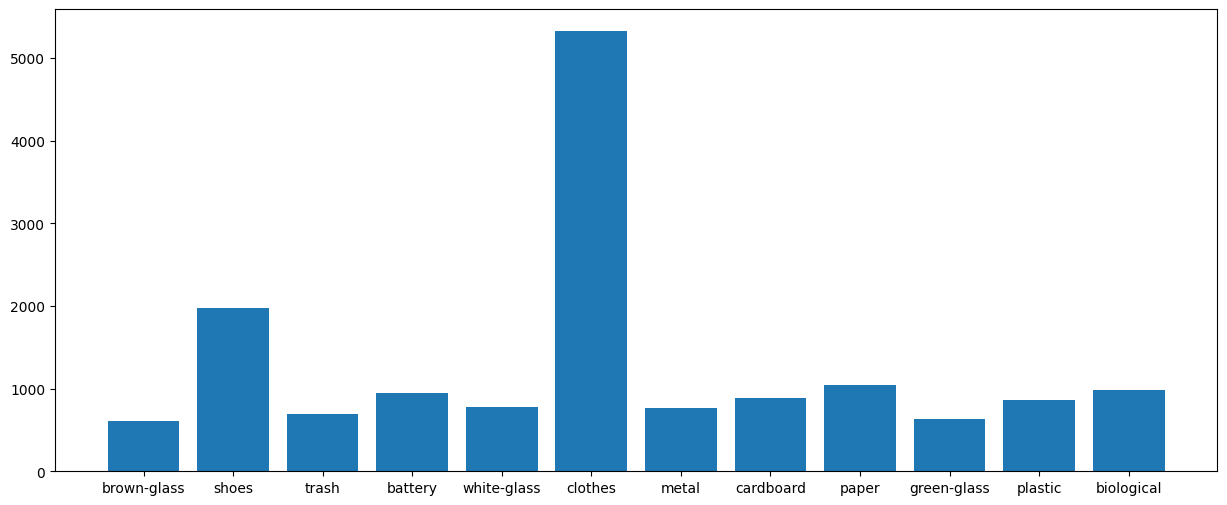

In [8]:
#representing in a graph
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.bar(labels,dataset_count.values())
plt.show()

In [9]:
# making train and test directory
os.makedirs('dataset', exist_ok=True)
train_dir = os.path.join('dataset', "train")
test_dir = os.path.join('dataset', "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [10]:
#splittting the dataset into 80:20 ratio
import shutil
import random
for label in os.listdir('garbage_classification'):
    label_path = os.path.join('garbage_classification', label)
    if os.path.isdir(label_path):
        os.makedirs(os.path.join(train_dir, label), exist_ok=True) # creating directories of each class train
        os.makedirs(os.path.join(test_dir, label), exist_ok=True) # creating directories of each class in test
        images = os.listdir(label_path)
        random.shuffle(images)

        #spliting the dataset
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        #copying the images
        for img in train_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(train_dir, label, img))
        for img in test_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(test_dir, label, img))


In [11]:
# setting train and test path
train_path = os.path.join('dataset', "train")
test_path = os.path.join('dataset', "test")
print(train_path)
print(test_path)

dataset/train
dataset/test


In [12]:
#Setting the image height and width
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [13]:
#resizing the images in train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 12409 files belonging to 12 classes.


2025-01-11 10:13:32.380935: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-11 10:13:32.380970: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: wasteserver-0
2025-01-11 10:13:32.380974: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: wasteserver-0
2025-01-11 10:13:32.381064: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.54.14
2025-01-11 10:13:32.381078: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.199.2
2025-01-11 10:13:32.381082: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.199.2 does not match DSO version 550.54.14 -- cannot find working devices in this configuration


In [14]:
#resizing the images in test directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3106 files belonging to 12 classes.


In [15]:
test_dataset.class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [16]:
class_names = train_dataset.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [17]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [18]:
#preprocessing the train and test dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

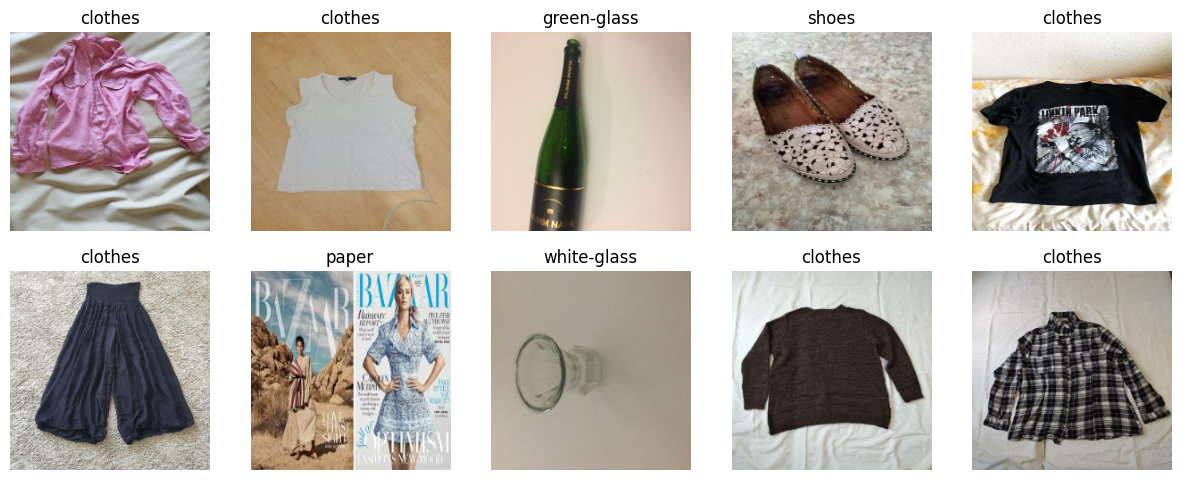

In [20]:
#displaying atleast 10 images after preprocessing and after auto tuning
import matplotlib.pyplot as plt
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(min(10, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.show()


In [21]:
data_path = 'garbage_classification'
total_imgs = 0
for class_ in os.listdir(data_path):
    count_class = 0
    for photo in os.listdir(data_path + '/' + class_):
        count_class += 1
        total_imgs += 1
    print(str(class_) + " has " + str(count_class) + " images.")
print('Total images in garbage collection = ',total_imgs) 

brown-glass has 607 images.
shoes has 1977 images.
trash has 697 images.
battery has 945 images.
white-glass has 775 images.
clothes has 5325 images.
metal has 769 images.
cardboard has 891 images.
paper has 1050 images.
green-glass has 629 images.
plastic has 865 images.
biological has 985 images.
Total images in garbage collection =  15515


In [22]:
#In training dataset
train_imgs = 0
for class_ in os.listdir(train_path):
    count_class = 0
    for photo in os.listdir(train_path + '/' + class_):
        train_imgs += 1
        count_class += 1
    print(str(class_) + " has " + str(count_class) + " images.")
print('-----------------------------------------------')
print('Total images in training dataset = ',train_imgs) 
print('-----------------------------------------------')

brown-glass has 485 images.
shoes has 1581 images.
trash has 557 images.
battery has 756 images.
white-glass has 620 images.
clothes has 4260 images.
metal has 615 images.
cardboard has 712 images.
paper has 840 images.
green-glass has 503 images.
plastic has 692 images.
biological has 788 images.
-----------------------------------------------
Total images in training dataset =  12409
-----------------------------------------------


In [23]:
#In testing dataset
test_imgs = 0
for class_ in os.listdir(test_path):
    count_class = 0
    for photo in os.listdir(test_path + '/' + class_):
        count_class += 1
        test_imgs += 1
    print(str(class_) + " has " + str(count_class) + " images.")
print('-----------------------------------------------')
print('Total images in training dataset = ',test_imgs) 
print('-----------------------------------------------')

brown-glass has 122 images.
shoes has 396 images.
trash has 140 images.
battery has 189 images.
white-glass has 155 images.
clothes has 1065 images.
metal has 154 images.
cardboard has 179 images.
paper has 210 images.
green-glass has 126 images.
plastic has 173 images.
biological has 197 images.
-----------------------------------------------
Total images in training dataset =  3106
-----------------------------------------------


In [24]:
train_df = pd.DataFrame(columns=['filename','class'])
for i in os.listdir('dataset/train'):
    filepath='dataset/train/'+i
    for j in os.listdir(filepath):
        train_data = pd.DataFrame({'filename':[j], 'class':[i]})
        #print(train_data)
        train_df = pd.concat([train_df,train_data], ignore_index=True)
train_df
        

,filename,class
0,brown-glass514.jpg,brown-glass
1,brown-glass222.jpg,brown-glass
2,brown-glass362.jpg,brown-glass
3,brown-glass498.jpg,brown-glass
4,brown-glass453.jpg,brown-glass
...,...,...
12404,biological506.jpg,biological
12405,biological591.jpg,biological
12406,biological358.jpg,biological
12407,biological318.jpg,biological


In [25]:
test_df = pd.DataFrame(columns=['filename','class'])
for i in os.listdir('dataset/test'):
    filepath='dataset/test/'+i
    for j in os.listdir(filepath):
        test_data = pd.DataFrame({'filename':[j], 'class':[i]})
        test_df = pd.concat([test_df,test_data], ignore_index=True)
test_df

,filename,class
0,brown-glass561.jpg,brown-glass
1,brown-glass444.jpg,brown-glass
2,brown-glass30.jpg,brown-glass
3,brown-glass354.jpg,brown-glass
4,brown-glass526.jpg,brown-glass
...,...,...
3101,biological634.jpg,biological
3102,biological397.jpg,biological
3103,biological941.jpg,biological
3104,biological573.jpg,biological


In [26]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [28]:
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax'),
    ])


In [29]:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [30]:
os.makedirs('modes',exist_ok=True)

In [31]:
# Checkpoint highest accuracy
#will save the best version of the model with highest accuracy
checkpoint_high_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_highest_accuracy.keras",
    monitor="val_accuracy", # monitoring validation accuracy
    save_best_only=True,
    mode="max",
    verbose=1
)

# Checkpoint lowest loss
#will save the best version of the model with lowest loss
checkpoint_low_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_lowest_loss.keras",
    monitor="val_loss", # monitoring validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=30,            # Stop training after 30 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 346112)            0

In [35]:
import time
start_time = time.time()
print('Start Time = ', start_time)
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[checkpoint_high_acc, checkpoint_low_loss,early_stopping,reduce_lr])
end_time = time.time()
print('End Time =', end_time)

Start Time =  1736590425.4766176
Epoch 1/50
 13/388 [>.............................] - ETA: 28:27 - loss: 7.8064 - accuracy: 0.1298

KeyboardInterrupt: 

In [33]:
print('Time Taken using super computer with 8 core cpus and 16GB memory=',(end_time-start_time)/60,'minutes')

Time Taken using super computer with 8 core cpus and 16GB memory= 10.11821045478185 minutes


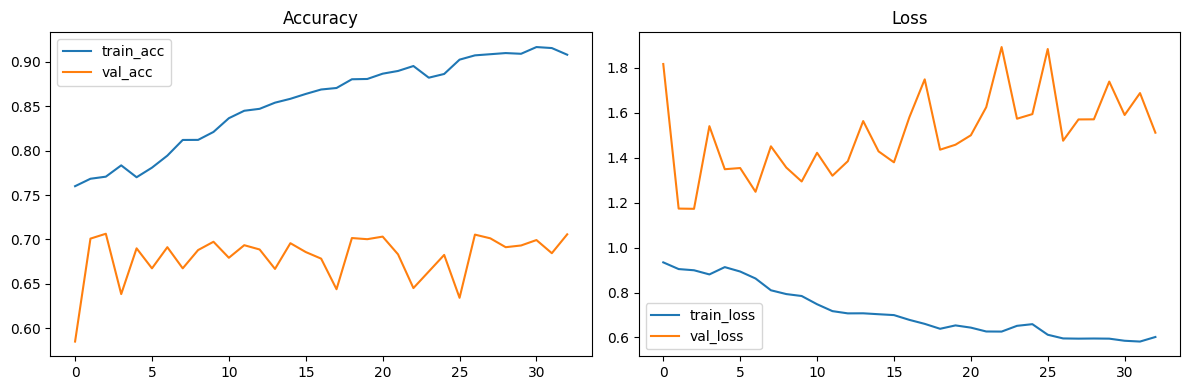

In [34]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(train_acc, label="train_acc")
axs[0].plot(val_acc, label="val_acc")
axs[0].set_title("Accuracy")
axs[0].legend()
axs[1].plot(train_loss, label="train_loss")
axs[1].plot(val_loss, label="val_loss")
axs[1].set_title("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [35]:
#evaluating the model
eval = model.evaluate(test_dataset)
print(eval)

98/98 [==============================] - 2s 17ms/step - loss: 1.1728 - accuracy: 0.7064
[1.1727663278579712, 0.7063747644424438]


In [36]:
from tensorflow.keras.models import load_model
model_high_accuracy = load_model("modes/base_model_highest_accuracy.keras")
model_low_loss = load_model("modes/base_model_lowest_loss.keras")

In [37]:
eval = model_high_accuracy.evaluate(test_dataset) 
print(eval)

98/98 [==============================] - 2s 17ms/step - loss: 1.1728 - accuracy: 0.7064
[1.1727663278579712, 0.7063747644424438]


In [38]:
print(model_low_loss.evaluate(test_dataset)) 

98/98 [==============================] - 2s 17ms/step - loss: 1.1132 - accuracy: 0.6806
[1.113200306892395, 0.680618166923523]


In [39]:
print(model.evaluate(test_dataset))

98/98 [==============================] - 2s 17ms/step - loss: 1.1728 - accuracy: 0.7064
[1.1727663278579712, 0.7063747644424438]


In [40]:
import numpy as np

In [41]:
y_true=[]
y_pred=[]
for img, labels in test_dataset:
    print(labels)
    y_true.append(np.argmax(labels, axis=-1))
    y_pred.append(tf.argmax(model.predict(img), axis=-1).numpy())
print('Length of y_true =', len(y_true), 'and length of y_pred =', len(y_pred))

tf.Tensor(
[ 4 11 10  9  3  1  4  9  4  8  6  4 10  1 11  4  3  5  3  4  0  0  9  4
  1  4  4  6  0  4  3  4], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 129ms/step
tf.Tensor(
[ 9  4  6  8  4  1  4  3  3  4  1  4  4 11  4  4 10  7  5  4  8  4  7  2
  4  0  4  0  8  4 11  4], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 41ms/step
tf.Tensor(
[ 4  9  4  7  9  8  8 10 10  4  9  8 10  7  4  4  4  4  4  1  5  4  4  8
  9  4  4  0 10  4  4 10], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 40ms/step
tf.Tensor(
[ 9  5  4  4  6 11  9  5  4  4  9  1  3  9  4  2  9  1  0  4  5  4  4  9
  4  3  4  0  1  4  4  4], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 43ms/step
tf.Tensor(
[ 4 11  5  9  1  4  4  4  0  4  8  9  5  4  8  8  0  3 11  6  6  6 11  6
  4  4  3 10  4  1  4  1], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 44ms/step
tf.Tensor(
[ 9  3 10  7  4  7  4  8  8  9  9  1  8  6 

In [44]:
y_pred1 = []
for i in y_pred:
    print(i)
    y_pred1.append(np.argmax(i, axis=-1))
y_pred1

[ 7  7 10  9  7  4  4  9  4  8 11  4 10  1  9  4  4  0  3  4  0  0  9  4
  1  4  4  7  8  4  3  4]
[ 9  8  7  8  4  1  4  3  3  4  1  4  4 11  4  4 10  4  8  4  7  4  7  2
  4  9  4  0  7  4 11  4]
[ 4  9  4  7  9  0  7 10 11  4  3 10 10  7  4  4  1  4  4  1  5  4  4  8
  9  4  4  0 10  4  4 10]
[ 3  5  4  4  9 11  4  5  4  4  9  8  3  9  4  6  9  1  9  2  5  4  4  9
  4  3  3  9  1  4  4  4]
[ 4  9  5  9  1  4  4  4  0  4 11  4  5  4 10  7  9  3  7  9 11  7 11  0
  4  4  9 11  4  1  4  1]
[ 9  9  9  7  4 11  4  8  7  9 11  2  8  6  1 11  4  1  9  5  7  7  4  3
  9  9  4  4  4  4 11  4]
[ 7  4  9  4  4  4  3  9  4  1  4  7  4  4  4  9  4  7  8 11  6  4  4  4
  9  4  4  4  4  4  4  4]
[ 4 10  4  4  9 10  0 11  9  3  7 11 10  4  0  9  5  3  6  3  7  4  7 11
  7  4  0  2  4  9  4 10]
[ 2  4  0  4  4  4  3  4  3  4  8  4  2  9  4  8  9  7  7  9  4  4 11  7
  7 11  4  0  2  4  9  9]
[ 4  4  4  4  4 11  4  7  6 11  4  7 11  6  4  4  4  4  9  7  4  4  4  1
  4  4  4 11  9  2  1  4]
[ 7  3  5 

[10,
 13,
 8,
 5,
 10,
 5,
 19,
 7,
 22,
 5,
 7,
 21,
 18,
 2,
 0,
 14,
 2,
 7,
 16,
 9,
 10,
 24,
 0,
 23,
 8,
 31,
 17,
 11,
 1,
 12,
 6,
 1,
 7,
 25,
 10,
 21,
 4,
 4,
 26,
 12,
 15,
 13,
 26,
 3,
 1,
 20,
 4,
 22,
 15,
 0,
 27,
 16,
 30,
 22,
 10,
 17,
 20,
 4,
 20,
 15,
 5,
 14,
 16,
 23,
 17,
 2,
 26,
 4,
 22,
 16,
 8,
 12,
 6,
 10,
 4,
 10,
 7,
 21,
 1,
 13,
 2,
 2,
 8,
 23,
 0,
 23,
 10,
 14,
 1,
 22,
 16,
 2,
 7,
 2,
 2,
 6,
 25,
 1]

In [47]:
len(y_pred1)

98

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred1, average='weighted')
recall = recall_score(y_true, y_pred1, average='weighted')
f1 = f1_score(y_true, y_pred1, average='weighted')

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.4f}%")
print(f"F1 Score: {f1*100:.2f}%")


Precision: 39.4218%
Recall: 28.5714%
F1 Score: 30.7209%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
from sklearn.metrics import accuracy_score
# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred1)
# Print the accuracy score
print(f"Accuracy Score: {accuracy*100:.2f}%")

Accuracy Score: 28.57%
